<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Angewandte Geophysik II: Kap 10: Modellierung
## Simple model for magnetics
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

In this notebook, we define a simple sphere as mass for gravity modelling.
<img src="images/3Dsphere_mag.png" style="height:10cm">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lib_modelling
#lib_modelling.change_fontsize()

----
## Theory

The **magnetic flux** $\vec{B}$ [nT] for a **dipole** is defined as:
$$
\vec{B} = \frac{\mu_0}{4\pi} \frac{m}{r^3} \left[ 3 (\hat{m} \cdot \hat{r} ) \hat{r} - \hat{m} \right]
$$
with 
- $\mu_0=4\pi \times 10^{-7}$ [Vs/Am] the magnetic permeability of vacuum,
- $\vec{m}$ [Am$^2$] the magnetic dipole moment,
- $m=|\vec{m}|$ its absolute value,
- $r$ [m] the distance between center of sphere and observation point,
- $\hat{r}$ [-] the unit vector in the direction center of sphere-observation point.

We define the **coordinates** for the:
- **observation point** $\vec{r}_o=(x_o,y_o,z_o)^T$
- **center of sphere**  $\vec{r}_p=(x_p,y_p,z_p)^T$

Then, $r=|\vec{r}_p-\vec{r}_o|=\sqrt{(x_p-x_o)^2+(y_p-y_o)^2+(z_p-z_o)^2}$

Next, we represent **dipole moment** $m$ as the product of **magnetisation** $M$ [A/m] and **volume** $V$ [m$^3$]:
$$
m=M V
$$
and introduce a differential notation for the volume:
$$
V= \int\limits_V dV
$$

Then, magnetic flux becomes:
$$
\vec{B} = \frac{\mu_0}{4\pi} \frac{M V}{r^3} \left[ 3 (\hat{m} \cdot \hat{r} ) \hat{r} - \hat{m} \right]
$$
Note that we changed the unit vector $\hat{r}$ to its dimensional version $\vec{r}_p-\vec{r}_o$.

This equation is the base for both theoretical derivations of the gravity field and modelling.

----
## Sphere as model

We solve the volume integral for magnetic induction $\vec{B}$ for a sphere of radius $R$ [m]
buried with its center in the depth $\vec{r}_s=(x_p,y_p,z_p)^T$. We obtain (Lecture Angewandte Geophysik II):
$$
\begin{array}{rcl}
 \Delta B_x    & = & \frac{\mu_0}{4\pi} \frac{{4 \over 3} \pi R^3 M}{r^5}
                     \left( 3(\hat{m}_x r_x + \hat{m}_y r_y + \hat{m}_z r_z) r_x - r^2 m_x\right)\\
 \Delta B_y    & = & \frac{\mu_0}{4\pi} \frac{{4 \over 3} \pi R^3 M}{r^5}
                     \left( 3(\hat{m}_x r_x + \hat{m}_y r_y + \hat{m}_z r_z) r_y - r^2 m_y\right)\\
 \Delta B_z    & = & \frac{\mu_0}{4\pi} \frac{{4 \over 3} \pi R^3 M}{r^5}
                     \left( 3(\hat{m}_x r_x + \hat{m}_y r_y + \hat{m}_z r_z) r_z - r^2 m_z\right)\\
 \Delta T      & = & \hat{B}_x \Delta B_x + \hat{B}_y \Delta B_y + \hat{B}_z \Delta B_z
\end{array}
$$
Here, $\mu_0 = 10^{-7}$ Vs/Am is the permeability of vacuum,
$R$ [m] the radius of the sphere, $M$ [A/m] the magnetisation of the sphere,
$(x_o,y_o,z_o)$ [m] the coordinate of the observation point, and
$(x_p,y_p,z_p)$ [m] the coordinate of the center of the sphere.
Note that we replaced $\hat{r}$ wit $r$, thus the $r^5$ in the denominator.

We translate these three equations into a`python` function:

In [2]:
def dircos(incl,decl,azim):
    """
    !-----------------------------------------------------------------------
    ! Input parameters:
    ! incl [degrees]     - inclination positive below horizontal
    ! decl [degrees]     - declination positive east from north
    ! azim [degrees]     - azimuth of x axis in degrees positive east to north
    ! Output parameter:
    ! a,b,c              - three direction cosines
    !
    ! from: 
    ! Blakeley (1995): Potential theory in gravity & magnetic applications
    !-----------------------------------------------------------------------
    """
    deg2rad = np.pi / 180.

    a = np.cos(incl*deg2rad) * np.cos((decl-azim)*deg2rad)
    b = np.cos(incl*deg2rad) * np.sin((decl-azim)*deg2rad)
    c = np.sin(incl*deg2rad)
    return a,b,c

In [3]:
def mag_sphere (xo,yo,zo,xp,yp,zp,radius,earthincl,earthdecl,mag,incl,decl,theta):
    """
    !-----------------------------------------------------------------------
    ! Magnetic anomaly of a uniformly magnetised sphere.
    ! x-axis is north, z-axis vertically down
    !
    ! Input parameters:
    ! xo,yo,zo [m]         - location of observation point
    ! xp,yp,zp [m]         - location of center of sphere
    ! radius [m]           - radius of sphere
    ! earthincl [degrees]  - inclination of earth field, positive below horizontal
    ! earthdecl [degrees]  - declination of earth field, positive east of true north
    ! mag [A/m]            - magnetisation      
    ! incl [degrees]       - inclination of magnetisation, positive below horizontal
    ! decl [degrees]       - declination of magnetisation, positive east of true north
    ! theta [degrees]      - azimuth of x axis in degrees positive east to north
    !
    ! Output parameter:
    ! bx,by,bz [nT]        - Magnetic induction component at observation point
    ! t [nT]               - Total field at observation point
    !
    ! from:
    ! Blakeley (1995): Potential theory in gravity & magnetic applications
    !-----------------------------------------------------------------------
    """
    mu04pi  = 1.000e-7      # Vs/Am
    t2nt    = 1.e9          # T -> nT
    mx,my,mz = dircos (incl,decl,theta)
    fx,fy,fz = dircos (earthincl,earthdecl,theta)

    rx   = xo - xp
    ry   = yo - yp
    rz   = zo - zp
    r2   = rx**2 + ry**2 + rz**2
    if (r2 == 0):
        print ('mag_sphere: obs point in centrum of sphere')
    r    = np.sqrt(r2)
    r5   = r**5
    dot  = rx*mx + ry*my + rz*mz
    moment = 4./3.*np.pi*mag*radius**3
    bx = t2nt * mu04pi * moment * (3.*dot*rx - r2*mx) / r5
    by = t2nt * mu04pi * moment * (3.*dot*ry - r2*my) / r5
    bz = t2nt * mu04pi * moment * (3.*dot*rz - r2*mz) / r5
    t  = fx*bx + fy*by + fz*bz
    return bx,by,bz,t

----
## 1D profile

We test our function. Define a box with 2 m side length, thus $a=b=c=2$m. 
Its volume is $V_b=a b c$.

From the volume of a sphere, $V_s={{4}\over{3}} \pi R^3$, the equivalent sphere radius $R$ follows from
$V_b=V_s$:
$$
R^3 = \frac{3 a b c}{4 \pi} 
$$

Using $a=b=c=2$ m, results in $R \simeq 1.24$ m.

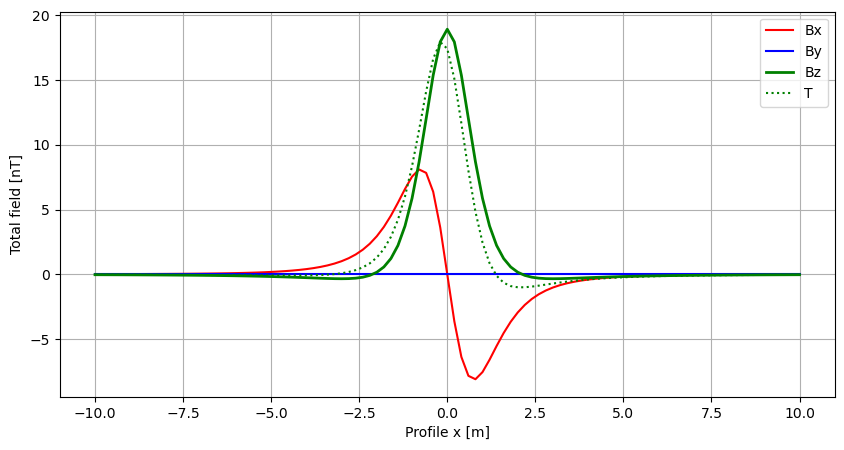

In [4]:
xmin=-10;xmax=10
x = np.linspace(xmin,xmax,101)
mag_bx = np.array([])
mag_by = np.array([])
mag_bz = np.array([])
mag_t  = np.array([])
for i in range(len(x)):
    bx,by,bz,t = mag_sphere(xo=x[i],yo=0,zo=0,xp=0,yp=0,zp=1.5,radius=1.24,
                        earthincl=67.,earthdecl=0.,mag=0.04,incl=90.,decl=0.,theta=0.)
    mag_bx = np.append(mag_bx,bx)
    mag_by = np.append(mag_by,by)
    mag_bz = np.append(mag_bz,bz)
    mag_t  = np.append(mag_t,t)
    
plt.figure(figsize=(10,5))
plt.xlabel('Profile x [m]')
plt.ylabel('Total field [nT]')
plt.plot(x,mag_bx,color='red',label='Bx')
plt.plot(x,mag_by,color='blue',label='By')
plt.plot(x,mag_bz,color='green',label='Bz',linewidth=2)
plt.plot(x,mag_t,color='green',label='T',linestyle=':')
plt.legend()
plt.grid()

----
## 2D map

Next we plan a two-dimensional survey (east,north as coordinates).

We define an anomaly using a sphere with radius $R$ and position $(x_p,y_p,z_p)$ of center of the sphere.

In [5]:
R  = 7.
xp = 5. #0.
yp = 0.
zp = 10.

(101, 201) (101, 201)


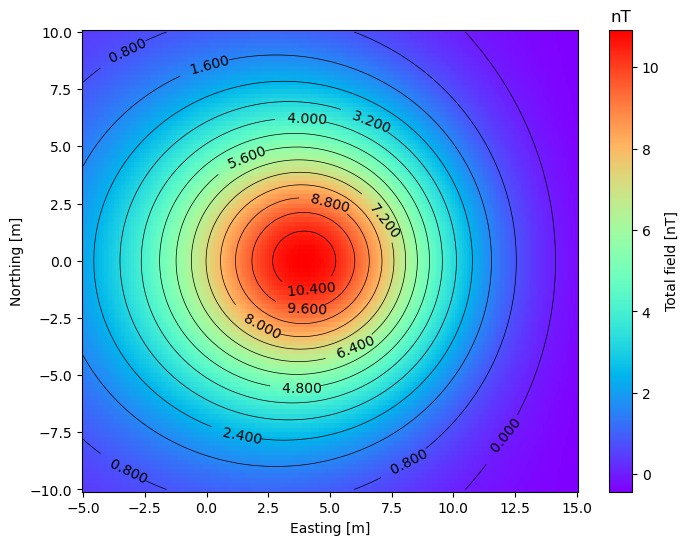

In [6]:
eastmin  = -5;eastmax=15
east     = np.linspace(eastmin,eastmax,201)
northmin = -10;northmax=10
north    = np.linspace(northmin,northmax,101)

EAST,NORTH = np.meshgrid(east,north)
TOTAL=0*EAST
print(EAST.shape,NORTH.shape)

for j in range(len(east)):
    for i in range(len(north)):
        bx,by,bz,t = mag_sphere(xo=east[j],yo=north[i],zo=0,xp=xp,yp=yp,zp=zp,radius=R,
                        earthincl=67.,earthdecl=0.,mag=0.04,incl=90.,decl=0.,theta=0.)
        TOTAL[i,j] = t

#plot figure
fig,axs = plt.subplots(1,1,figsize=(8,6))
# image and contours
axs.set_xlabel('Easting [m]')
axs.set_ylabel('Northing [m]')
im=axs.pcolormesh(EAST,NORTH,TOTAL,cmap = plt.get_cmap('rainbow'))
CS=axs.contour(EAST,NORTH,TOTAL,15,linewidths = 0.5, colors = 'k')
plt.clabel(CS,inline=1,fontsize=10,fmt='%8.3f')

# colorbar
cbar=fig.colorbar(im,ax=axs)
cbar.ax.set_title('nT')
cbar.set_label('Total field [nT]')

<IPython.core.display.Javascript object>


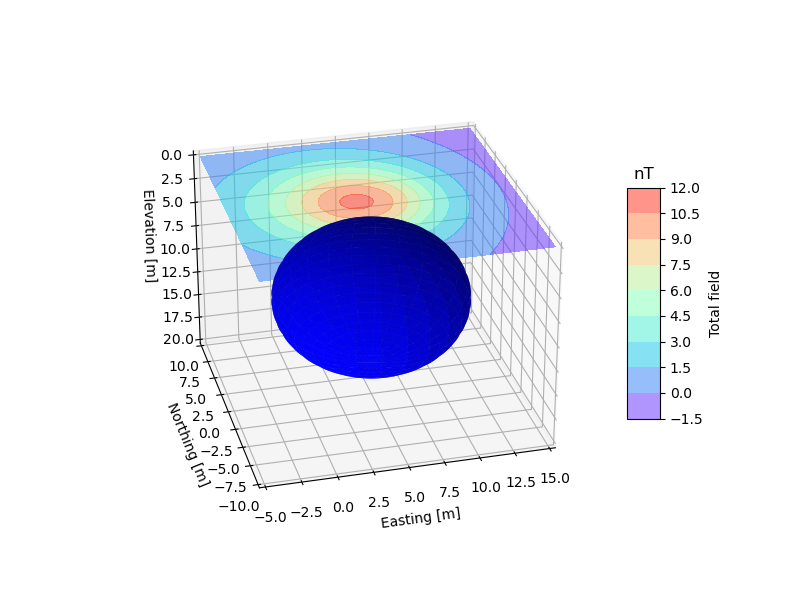

In [7]:
%matplotlib notebook

axs = plt.figure(figsize=(8,6)).add_subplot(projection='3d')
# 3D axes
axs.set_xlim(eastmin,eastmax)
axs.set_ylim(northmin,northmax)
axs.set_zlim((xmax-xmin), 0)
axs.set_xlabel('Easting [m]')
axs.set_ylabel('Northing [m]')
axs.set_zlabel('Elevation [m]')

# Total field as 2D plot
surf=axs.contourf(EAST,NORTH,TOTAL,zdir='z',offset=0,alpha=0.5,cmap = plt.get_cmap('rainbow'))

# sphere as 3D object
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
xsphere = xp + R * np.outer(np.cos(u), np.sin(v))
ysphere = yp + R * np.outer(np.sin(u), np.sin(v))
zsphere = zp + R * np.outer(np.ones(np.size(u)), np.cos(v))
axs.plot_surface(xsphere,ysphere,zsphere,rstride=4,cstride=4,color='b',linewidth=0,alpha=0.9)

# colorbar
cbar=fig.colorbar(surf, shrink=0.5, aspect=7)
cbar.ax.set_title('nT')
cbar.set_label('Total field')

... done